In [660]:
import pandas as pd
import numpy as np
import sklearn
import torch
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
warnings.filterwarnings("ignore")

In [661]:
train = pd.read_csv("C://Users//HOME//Downloads//spaceship-titanic//train.csv")
test = pd.read_csv("C://Users//HOME//Downloads//spaceship-titanic//test.csv")

In [662]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [663]:
def preprocess(data):
  data["Group_num"] = data["PassengerId"].agg(lambda x: int(x[0:4]))
  data["Side"] = data["Cabin"].agg(lambda x: str(x)[-1] if not pd.isna(x) else "No")
  data["Deck"] = data["Cabin"].agg(lambda x: str(x)[0] if not pd.isna(x) else "No")
  data.index = data["PassengerId"]
  data = data.drop(columns=["Name", "Cabin", "PassengerId"])
  data = data.fillna({"HomePlanet" : "No", "VIP" : False, "Destination" : "No", "Age" : data["Age"].median(),
                        "ShoppingMall" : data["ShoppingMall"].mean()
                        })

  data[(data["CryoSleep"] == True) & 
    (data[["VRDeck", "Spa", "RoomService", "FoodCourt"]].isna().sum() != 0)][["VRDeck", "Spa", "RoomService", "FoodCourt"]] = 0
    
  group_par = "Age"
  cryo_by_family = data.groupby(group_par)["CryoSleep"].mean()
  vr_by_family = data.groupby(group_par)["VRDeck"].mean()
  spa_by_family = data.groupby(group_par)["Spa"].mean()
  room_by_family = data.groupby(group_par)["RoomService"].mean()
  food_by_family = data.groupby(group_par)["FoodCourt"].mean()
  num_of_members = data.groupby("Group_num")["Group_num"].count()

  data["VRDeck"][data["VRDeck"].isna()] = data[data["VRDeck"].isna()].agg(axis=1, func=lambda x: vr_by_family.loc[x[group_par]])
  data["FoodCourt"][data["FoodCourt"].isna()] = data[data["FoodCourt"].isna()].agg(axis=1, func=lambda x: food_by_family.loc[x[group_par]])
  data["RoomService"][data["RoomService"].isna()] = data[data["RoomService"].isna()].agg(axis=1, func=lambda x: room_by_family.loc[x[group_par]])
  data["Spa"][data["Spa"].isna()] = data[data["Spa"].isna()].agg(axis=1, func=lambda x: spa_by_family.loc[x[group_par]])
  data["CryoSleep"][data["CryoSleep"].isna()] = data[data["CryoSleep"].isna()].agg(axis=1, func=lambda x: True if cryo_by_family.loc[x[group_par]] else False)
  data["Alone"] = data["Group_num"].agg(lambda x: True if num_of_members.loc[x] == 1 else False)
    
  data = data.drop(columns=["Group_num"])
  data = data.fillna({"VRDeck" : 0,
                     "RoomService" : 0,
                     "Spa" : 0,
                     "FoodCourt" : 0})
  return data

In [664]:
IDs = test["PassengerId"]
data = preprocess(pd.concat([train, test]))

In [665]:
test = data.loc[test["PassengerId"]]
train = data.loc[train["PassengerId"]]

In [666]:
X, y = train.drop(columns=["Transported"]), train["Transported"]
test = test.drop(columns=["Transported"])
X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)
cols = test.columns
scaler = StandardScaler()

In [667]:
y = y.astype(bool)

In [668]:
test.shape, X.shape, y.shape

((4277, 25), (8693, 25), (8693,))

In [669]:
X = scaler.fit_transform(X)
test = scaler.transform(test)

In [670]:
model = SVC()

param_grid = {
    'C': np.arange(1, 5),
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
}
clf = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, scoring="accuracy", cv = 3, verbose=2)
clf.fit(X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4]),
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='accuracy', verbose=2)

In [671]:
clf.best_score_, clf.best_params_

(0.7891408411436626, {'C': 1, 'kernel': 'linear'})

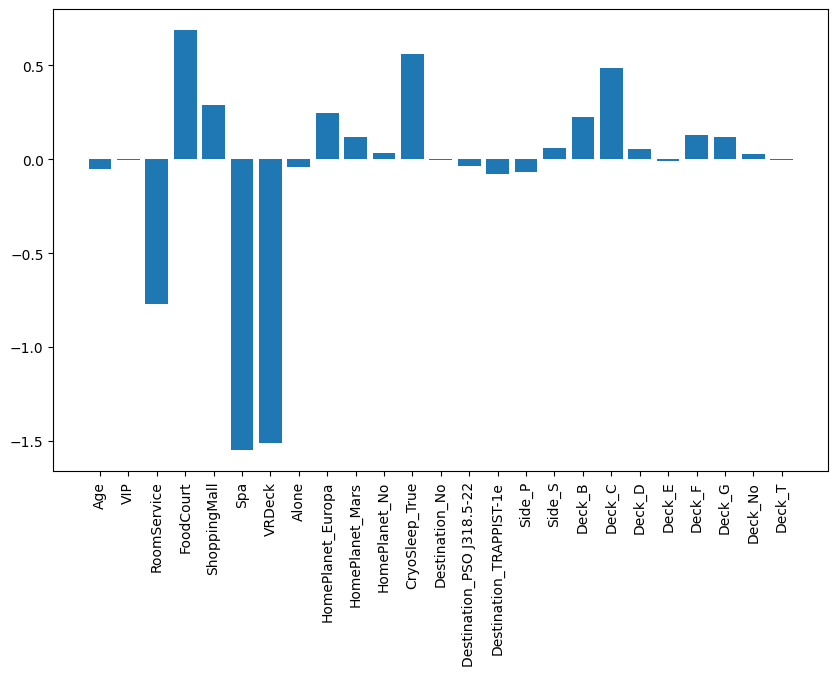

In [672]:
estimator = clf.best_estimator_
plt.figure(figsize=(10,6))
plt.bar(cols, estimator.coef_.reshape(-1))
plt.xticks(rotation=90)
None

In [673]:
SVC_answers = estimator.predict(test)

In [674]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth' : [3,5,8,10,12,15],
    'criterion' : ['gini', 'entropy', 'log_loss']
}
clf = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, scoring="accuracy", cv = 3, verbose=2)
clf.fit(X, y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 8, 10, 12, 15],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy', verbose=2)

In [677]:
clf.best_score_, clf.best_params_

(0.7965044632211566,
 {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 150})

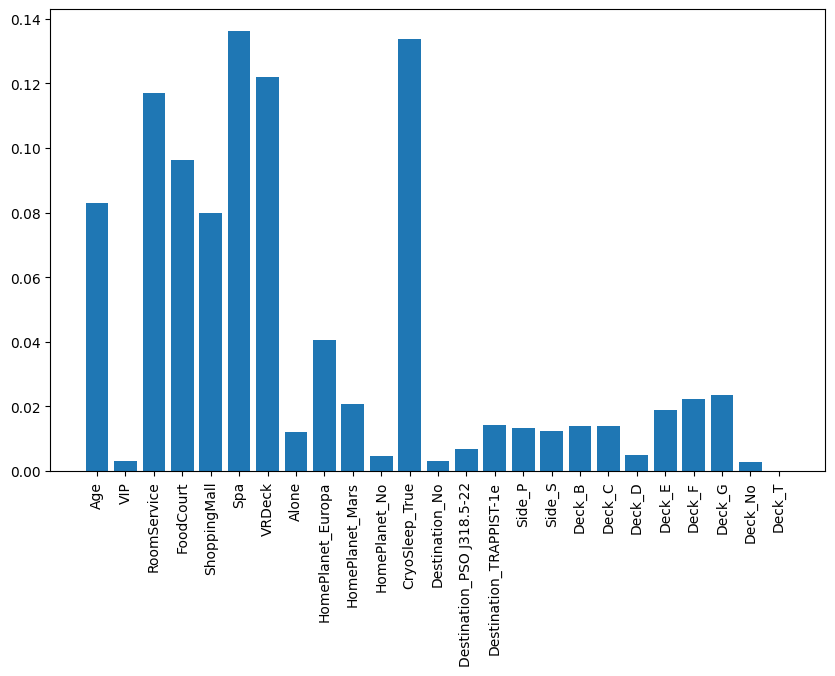

In [678]:
estimator = clf.best_estimator_
plt.figure(figsize=(10,6))
plt.bar(cols, estimator.feature_importances_.reshape(-1))
plt.xticks(rotation=90)
None

In [679]:
RF_answers = estimator.predict(test)

In [680]:
model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=6, early_stopping_rounds=10)
model.fit(X[:int(0.8*X.shape[0])], y[:int(0.8*X.shape[0])], eval_set=(X[int(0.8*X.shape[0]):], y[int(0.8*X.shape[0]):]))

0:	learn: 0.6449111	test: 0.6419267	best: 0.6419267 (0)	total: 13.5ms	remaining: 4.03s
1:	learn: 0.6154975	test: 0.6130001	best: 0.6130001 (1)	total: 37ms	remaining: 5.5s
2:	learn: 0.5927303	test: 0.5910798	best: 0.5910798 (2)	total: 53.5ms	remaining: 5.29s
3:	learn: 0.5705783	test: 0.5701210	best: 0.5701210 (3)	total: 65.7ms	remaining: 4.86s
4:	learn: 0.5495128	test: 0.5477256	best: 0.5477256 (4)	total: 77.8ms	remaining: 4.59s
5:	learn: 0.5335043	test: 0.5305557	best: 0.5305557 (5)	total: 105ms	remaining: 5.14s
6:	learn: 0.5204007	test: 0.5161103	best: 0.5161103 (6)	total: 120ms	remaining: 5.03s
7:	learn: 0.5073452	test: 0.5037096	best: 0.5037096 (7)	total: 132ms	remaining: 4.81s
8:	learn: 0.4963864	test: 0.4916257	best: 0.4916257 (8)	total: 144ms	remaining: 4.65s
9:	learn: 0.4885233	test: 0.4831978	best: 0.4831978 (9)	total: 172ms	remaining: 5s
10:	learn: 0.4811303	test: 0.4755989	best: 0.4755989 (10)	total: 177ms	remaining: 4.66s
11:	learn: 0.4732410	test: 0.4685970	best: 0.4685970 

In [681]:
CatBoost_answers = model.predict(test)

In [682]:
(CatBoost_answers == RF_answers).mean(), (CatBoost_answers == SVC_answers).mean(), (RF_answers == SVC_answers).mean()

(0.9499649286883329, 0.9310264203881226, 0.9179331306990881)

In [683]:
answer = np.concatenate([CatBoost_answers.reshape(-1,1), RF_answers.reshape(-1,1), SVC_answers.reshape(-1,1)], axis=1)
mask = answer.sum(axis = 1) > 1

In [685]:
answer = pd.DataFrame({"Transported" : mask}, index=IDs)
answer.to_csv("answer.csv")